# Module 2: Model Calibration Assignment 
## Answers for programming questions

Welcome to your second assignment in Financial Engineering and Risk Management 3.

This exercise gives you a hands-on experience on options visualization, implied volatility, and model calibration on virtual option data. By virtual option we mean the option that do not exist in real market, but instead simulated from stochastic models.

**After this assignment you will:**
- Be able to do descriptive analysis (visualization, implied volatility) for option pricing
- Be able to find an optimal initial start point for optimization routine
- Be able to calibrate stochastic models on dataset

Note: In order to submit your answer, you need to manually copy the answer from your notebook to the Programming Assignment.

## Import necessary modules

In [9]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
# for interactive figures
#%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate
from scipy.stats import norm
from scipy import optimize
import cmath
import math

## Load data from Excel

In [10]:
# file name
excel_file = 'data_apple.xlsx'
# read data into a data frame
df = pd.read_excel(excel_file)
# create the 'Mid' variable
df['Mid'] = df[['Bid','Ask']].mean(axis=1)

In [11]:
# see some of the data
df.head()

,Option_type,Maturity_days,Strike,Ticker,Bid,Ask,Last,IVM,Volm,Mid
0,Call,25,170.0,AAPL 8/17/18 C170,21.150000,21.400000,20.65,30.762677,7,21.275000
1,Call,25,172.5,AAPL 8/17/18 C172.5,18.649994,19.049988,0.00,29.173643,0,18.849991
2,Call,25,175.0,AAPL 8/17/18 C175,16.449997,16.649994,16.50,28.306871,19,16.549995
3,Call,25,177.5,AAPL 8/17/18 C177.5,14.100000,14.400000,0.00,26.967507,0,14.250000
4,Call,25,180.0,AAPL 8/17/18 C180,12.050000,12.150000,12.10,26.321682,1129,12.100000


### Question 1 (Plotting put options surface) 
Plotting put options surface for the given AAPL data. Use linear interpolation for missing strikes.
#### Note: This question is ungraded

In [12]:
# define strikes and maturities
#all_strikes = np.sort(df_calls.Strike.unique())
all_strikes = np.arange(170., 210. + 2.5, 2.5)
all_maturities = np.sort(df.Maturity_days.unique())
print(all_strikes)
print(all_maturities)

[170.  172.5 175.  177.5 180.  182.5 185.  187.5 190.  192.5 195.  197.5
 200.  202.5 205.  207.5 210. ]
[ 25  60  88 116 151 179 333 543 697]


In [13]:
df_puts = df[df['Option_type'] == 'Put'][['Maturity_days', 'Strike', 'Mid']]
df_puts.head()

,Maturity_days,Strike,Mid
17,25,170.0,0.435
18,25,172.5,0.570
19,25,175.0,0.765
20,25,177.5,1.035
21,25,180.0,1.415


In [18]:
# define a grid for the surface
X, Y = np.meshgrid(all_strikes, all_maturities)
Z_p = np.empty([len(all_maturities), len(all_strikes)])
print(all_maturities)

[ 25  60  88 116 151 179 333 543 697]


In [15]:
# Use linear interpolation to fill missing strikes
for i in range(len(all_maturities)):
    ### part need to be finished ###
    # roughly 2 lines
    ### --------------###
    f = interpolate.interp1d(s, price, bounds_error=False, fill_value=0)
    Z_p[i, :] = f(all_strikes) 

NameError: name 's' is not defined

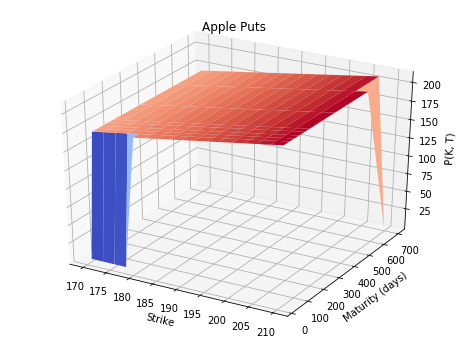

In [16]:
# plot the surface
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_p, cmap=cm.coolwarm)
ax.set_ylabel('Maturity (days)') 
ax.set_xlabel('Strike') 
ax.set_zlabel('P(K, T)')
ax.set_title('Apple Puts')
plt.savefig('fig3.png')
plt.show()

### Question 2 (Calculating implied volatility)
Calculate the implied volatility of the following call option and put option. The implied volatility is the volatility that makes the option price from BS model equal to its actual market price.

$K$ = 190

$T-t$ = 151/365

$q$ = 0.005

$r$ = 0.0245

$S_0$ = 190.3

$C$ = 10.875

$P$ = 9.625

#### Note: This question is graded, please use the results to answer questions 1-2

In [19]:
# select strike and maturity
K = 190.
T_days = 151
T_years = 1.* T_days / 365

# dividend rate
q = 0.005

# risk free rate
r = 0.0245

# spot price
S_0 = 190.3

# price
P_call = 10.875
P_put = 9.625

In [22]:
# utilize the following black scholes calculator to get the price from BS model
def BS_d1(S, K, r, q, sigma, tau):
    ''' Computes d1 for the Black Scholes formula '''
    d1 = 1.0*(np.log(1.0 * S/K) + (r - q + sigma**2/2) * tau) / (sigma * np.sqrt(tau))
    return d1

def BS_d2(S, K, r, q, sigma, tau):
    ''' Computes d2 for the Black Scholes formula '''
    d2 = 1.0*(np.log(1.0 * S/K) + (r - q - sigma**2/2) * tau) / (sigma * np.sqrt(tau))
    return d2

def BS_price(type_option, S, K, r, q, sigma, T, t=0):
    ''' Computes the Black Scholes price for a 'call' or 'put' option '''
    tau = T - t
    d1 = BS_d1(S, K, r, q, sigma, tau)
    d2 = BS_d2(S, K, r, q, sigma, tau)
    if type_option == 'call':
        price = S * np.exp(-q * tau) * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    elif type_option == 'put':
        price = K * np.exp(-r * tau) * norm.cdf(-d2) - S * np.exp(-q * tau) * norm.cdf(-d1) 
    return price

### part need to be finished ###
# auxiliary function for computing implied vol
def aux_imp_vol(sigma, P, type_option, S, K, r, q, T, t=0):
    # roughly 1-2 lines
    return P-BS_price(type_option, S, K, r, q, sigma ,T)
### --------------###

In [23]:
# compute implied vol
imp_vol_call = optimize.brentq(aux_imp_vol, 0.01, 0.4, args=(P_call, 'call', S_0, K, r, q, T_years))
imp_vol_put = optimize.brentq(aux_imp_vol, 0.01, 0.4, args=(P_put, 'put', S_0, K, r, q, T_years))

In [24]:
imp_vol_call, imp_vol_put

(0.20505479848219343, 0.2169237544182971)

### Question 3 (Searching optimal initial point)
Given two sets of initial parameters of Heston model. P1 = (1.0, 0.02, 0.05, -0.4, 0.08), P2 = (3.0, 0.06, 0.10, -0.6, 0.04).

Please find the optimal initial parameters set. The optimal parameters set should between the given two parameters sets.

#### Note: This question is graded, please use the results to answer questions 3-6

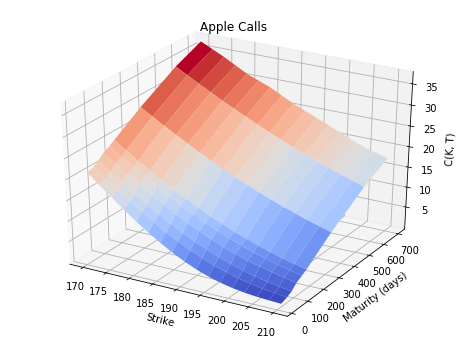

In [25]:
# import module needed for option pricing
import readPlotOptionSurface 
import modulesForCalibration as mfc

In [26]:
# Parameters
alpha = 1.5
eta = 0.2
    
n = 12

# Model
model = 'Heston' 


# risk free rate
r = 0.0245
# dividend rate
q = 0.005
# spot price
S0 = 190.3

In [27]:
params1 = (1.0, 0.02, 0.05, -0.4, 0.08)
params2 = (3.0, 0.06, 0.10, -0.6, 0.04)

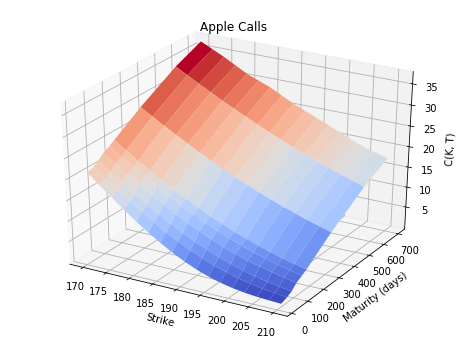

In [28]:
iArray = []
rmseArray = []
rmseMin = 1e10

maturities, strikes, callPrices = readPlotOptionSurface.readNPlot()

marketPrices = callPrices
maturities_years = maturities/365.0

In [29]:
### part need to be finished ###
#  Note: You could use the eValue function in modulesForCalibration (mfc) to calculate the mean square error. 
#  For more detail about this function, please refer to modulesForCalibration.py

## roughly 8-10 lines
for i in mfc.myRange(0, 1, 0.05):
    
    params = i*np.array(params1) + (1.0-i)*np.array(params2)
    iArray.append(i)
     
    rmse = mfc.eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)
    rmseArray.append(rmse)
    if (rmse < rmseMin):
        rmseMin = rmse
        optimParams = params
print(rmseMin)
print(optimParams)
### --------------###

0.8658939945597758
[ 2.3     0.046   0.0825 -0.53    0.054 ]


### Question 4 (Heston Model Calibration)
Calibrate the Heston model for the given dataset ('Virtual Option Data.csv') by brute force. The searching range of parameters should be the followings:

$2.5 \leq \kappa \leq 3.0$ with step 2.5

$0.06 \leq \theta \leq 0.065$ with step 0.0025

$0.1 \leq \sigma \leq 0.3$ with step 0.05

$-0.675 \leq \rho \leq -0.625$ with step 0.025

$0.04 \leq v_0 \leq 0.06$ with step 0.01

#### Note: This question is graded, please use the results to answer questions 7-10

In [30]:
# use the following fixed Parameters to calibrate the model
S0 = 100
K = 80
k = np.log(K)
r = 0.05
q = 0.015

# Parameters setting in fourier transform
alpha = 1.5
eta = 0.2

n = 12
N = 2**n
# step-size in log strike space
lda = (2*np.pi/N)/eta

#Choice of beta
beta = np.log(S0)-N*lda/2

# Model
model = 'Heston'

In [31]:
# calculate characteristic function of different models
def generic_CF(u, params, T, model):
    
    if (model == 'GBM'):
        
        sig = params[0];
        mu = np.log(S0) + (r-q-sig**2/2)*T;
        a = sig*np.sqrt(T);
        phi = np.exp(1j*mu*u-(a*u)**2/2);
        
    elif(model == 'Heston'):
        
        kappa  = params[0];
        theta  = params[1];
        sigma  = params[2];
        rho    = params[3];
        v0     = params[4];

        tmp = (kappa-1j*rho*sigma*u);
        g = np.sqrt((sigma**2)*(u**2+1j*u)+tmp**2);
        
        pow1 = 2*kappa*theta/(sigma**2);

        numer1 = (kappa*theta*T*tmp)/(sigma**2) + 1j*u*T*r + 1j*u*math.log(S0);
        log_denum1 = pow1 * np.log(np.cosh(g*T/2)+(tmp/g)*np.sinh(g*T/2));
        tmp2 = ((u*u+1j*u)*v0)/(g/np.tanh(g*T/2)+tmp);
        log_phi = numer1 - log_denum1 - tmp2;
        phi = np.exp(log_phi);

    elif (model == 'VG'):
        
        sigma  = params[0];
        nu     = params[1];
        theta  = params[2];

        if (nu == 0):
            mu = math.log(S0) + (r-q - theta -0.5*sigma**2)*T;
            phi  = math.exp(1j*u*mu) * math.exp((1j*theta*u-0.5*sigma**2*u**2)*T);
        else:
            mu  = math.log(S0) + (r-q + math.log(1-theta*nu-0.5*sigma**2*nu)/nu)*T;
            phi = cmath.exp(1j*u*mu)*((1-1j*nu*theta*u+0.5*nu*sigma**2*u**2)**(-T/nu));

    return phi

# calculate option price by inverse fourier transform
def genericFFT(params, T):
    
    # forming vector x and strikes km for m=1,...,N
    km = []
    xX = []
    
    # discount factor
    df = math.exp(-r*T)
    
    for j in range(N):
        
        nuJ=j*eta
        km.append(beta+j*lda)
        
        psi_nuJ = df*generic_CF(nuJ-(alpha+1)*1j, params, T, model)/((alpha + 1j*nuJ)*(alpha+1+1j*nuJ))
        if j == 0:
            wJ = (eta/2)
        else:
            wJ = eta
        
        xX.append(cmath.exp(-1j*beta*nuJ)*psi_nuJ*wJ)
     
    yY = np.fft.fft(xX)
    
    cT_km = []    
    for i in range(N):
        multiplier = math.exp(-alpha*km[i])/math.pi
        cT_km.append(multiplier*np.real(yY[i]))
    
    return km, cT_km

# myRange(a, b) return a generator [a, a+1, ..., b], which is different from built-in generator Range that returns [a, a+1,..., b-1]. 
# You may use it to perform brute force
def myRange(start, finish, increment):
    while (start <= finish):
        yield start
        start += increment

In [32]:
# load virtual option data
data = pd.read_csv("Virtual Option Data.csv", index_col=0)

In [33]:
# generate strike and maturity array
strikes = np.array(data.index, dtype=float)
maturities = np.array(data.columns, dtype=float)
marketPrices = data.values

In [35]:
modelPrices = np.zeros_like(marketPrices)

maeMin = 1.0e6
### part need to be finished ###

ind_iter = 1
rmseMin = 1.0e6

for kappa in mfc.myRange(2.5,3,0.25):
    for theta in mfc.myRange(0.06,0.065,0.0025):
        for sig in mfc.myRange(0.1,0.3,0.05):
            for rho in mfc.myRange(-0.675,-0.625,0.025):
                for v0 in mfc.myRange(0.04,0.06,0.01):
                    params = []
                    params.append(kappa)
                    params.append(theta)
                    params.append(sig)
                    params.append(rho)
                    params.append(v0)
                    
                    print('i = ' + str(ind_iter))
                    ind_iter += 1
                    print(params)
                    rmse = mfc.eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)
                    
                    if (rmse < rmseMin):
                        rmseMin = rmse
                        params2 = params
                        print('\nnew min found')
                        print(rmseMin)
                        print(params2)
                        print('')

print('\nSolution of grid search:')                        
print(params2)
print('Optimal rmse = ' + str(rmseMin))

### --------------###

i = 1
[2.5, 0.06, 0.1, -0.675, 0.04]

new min found
17.14670464373844
[2.5, 0.06, 0.1, -0.675, 0.04]

i = 2
[2.5, 0.06, 0.1, -0.675, 0.05]

new min found
17.11100733728531
[2.5, 0.06, 0.1, -0.675, 0.05]

i = 3
[2.5, 0.06, 0.1, -0.675, 0.060000000000000005]

new min found
17.079420037911323
[2.5, 0.06, 0.1, -0.675, 0.060000000000000005]

i = 4
[2.5, 0.06, 0.1, -0.65, 0.04]
i = 5
[2.5, 0.06, 0.1, -0.65, 0.05]
i = 6
[2.5, 0.06, 0.1, -0.65, 0.060000000000000005]

new min found
17.077529455718047
[2.5, 0.06, 0.1, -0.65, 0.060000000000000005]

i = 7
[2.5, 0.06, 0.1, -0.625, 0.04]
i = 8
[2.5, 0.06, 0.1, -0.625, 0.05]
i = 9
[2.5, 0.06, 0.1, -0.625, 0.060000000000000005]

new min found
17.075636564715833
[2.5, 0.06, 0.1, -0.625, 0.060000000000000005]

i = 10
[2.5, 0.06, 0.15000000000000002, -0.675, 0.04]
i = 11
[2.5, 0.06, 0.15000000000000002, -0.675, 0.05]
i = 12
[2.5, 0.06, 0.15000000000000002, -0.675, 0.060000000000000005]
i = 13
[2.5, 0.06, 0.15000000000000002, -0.65, 0.04]
i = 14
[2.5, 0.0

i = 161
[2.75, 0.06, 0.2, -0.625, 0.05]
i = 162
[2.75, 0.06, 0.2, -0.625, 0.060000000000000005]
i = 163
[2.75, 0.06, 0.25, -0.675, 0.04]
i = 164
[2.75, 0.06, 0.25, -0.675, 0.05]
i = 165
[2.75, 0.06, 0.25, -0.675, 0.060000000000000005]
i = 166
[2.75, 0.06, 0.25, -0.65, 0.04]
i = 167
[2.75, 0.06, 0.25, -0.65, 0.05]
i = 168
[2.75, 0.06, 0.25, -0.65, 0.060000000000000005]
i = 169
[2.75, 0.06, 0.25, -0.625, 0.04]
i = 170
[2.75, 0.06, 0.25, -0.625, 0.05]
i = 171
[2.75, 0.06, 0.25, -0.625, 0.060000000000000005]
i = 172
[2.75, 0.06, 0.3, -0.675, 0.04]
i = 173
[2.75, 0.06, 0.3, -0.675, 0.05]
i = 174
[2.75, 0.06, 0.3, -0.675, 0.060000000000000005]
i = 175
[2.75, 0.06, 0.3, -0.65, 0.04]
i = 176
[2.75, 0.06, 0.3, -0.65, 0.05]
i = 177
[2.75, 0.06, 0.3, -0.65, 0.060000000000000005]
i = 178
[2.75, 0.06, 0.3, -0.625, 0.04]
i = 179
[2.75, 0.06, 0.3, -0.625, 0.05]
i = 180
[2.75, 0.06, 0.3, -0.625, 0.060000000000000005]
i = 181
[2.75, 0.0625, 0.1, -0.675, 0.04]
i = 182
[2.75, 0.0625, 0.1, -0.675, 0.05]
i

i = 327
[3.0, 0.0625, 0.15000000000000002, -0.675, 0.060000000000000005]
i = 328
[3.0, 0.0625, 0.15000000000000002, -0.65, 0.04]
i = 329
[3.0, 0.0625, 0.15000000000000002, -0.65, 0.05]
i = 330
[3.0, 0.0625, 0.15000000000000002, -0.65, 0.060000000000000005]
i = 331
[3.0, 0.0625, 0.15000000000000002, -0.625, 0.04]
i = 332
[3.0, 0.0625, 0.15000000000000002, -0.625, 0.05]
i = 333
[3.0, 0.0625, 0.15000000000000002, -0.625, 0.060000000000000005]
i = 334
[3.0, 0.0625, 0.2, -0.675, 0.04]
i = 335
[3.0, 0.0625, 0.2, -0.675, 0.05]
i = 336
[3.0, 0.0625, 0.2, -0.675, 0.060000000000000005]
i = 337
[3.0, 0.0625, 0.2, -0.65, 0.04]
i = 338
[3.0, 0.0625, 0.2, -0.65, 0.05]
i = 339
[3.0, 0.0625, 0.2, -0.65, 0.060000000000000005]
i = 340
[3.0, 0.0625, 0.2, -0.625, 0.04]
i = 341
[3.0, 0.0625, 0.2, -0.625, 0.05]
i = 342
[3.0, 0.0625, 0.2, -0.625, 0.060000000000000005]
i = 343
[3.0, 0.0625, 0.25, -0.675, 0.04]
i = 344
[3.0, 0.0625, 0.25, -0.675, 0.05]
i = 345
[3.0, 0.0625, 0.25, -0.675, 0.060000000000000005]
